<a href="https://colab.research.google.com/github/sruthikoyya/SummerIntership_NITR/blob/main/model_NITR_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model, Input
from tensorflow.keras.datasets import mnist
import numpy as np

In [ ]:
# Load and preprocess MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Normalize and convert to float32
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
#Data Preprocessing
X_train = tf.image.resize_with_pad(tf.expand_dims(X_train, -1), 32, 32)
X_test = tf.image.resize_with_pad(tf.expand_dims(X_test, -1), 32, 32)
X_train = tf.image.grayscale_to_rgb(X_train)
X_test = tf.image.grayscale_to_rgb(X_test)

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from tensorflow.keras import layers

def dcb_block(input_tensor):
    # Dilated conv with d=1
    d1 = layers.DepthwiseConv2D(kernel_size=3, dilation_rate=1, padding='same')(input_tensor)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(d1)

    # Dilated conv with d=3
    d3 = layers.DepthwiseConv2D(kernel_size=3, dilation_rate=3, padding='same')(input_tensor)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(d3)

    # Concatenate d1 and d3
    concat_13 = layers.Concatenate()([d1, d3])
    concat_13 = layers.BatchNormalization()(concat_13)
    concat_13 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(concat_13)

    # Multiply concat_13 and d3
    multiplied = layers.Multiply()([concat_13, d3])
    multiplied = layers.BatchNormalization()(multiplied)
    multiplied = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(multiplied)

    # Apply sigmoid to multiplied
    mul_sigmoid = layers.Activation('sigmoid')(multiplied)

    # Dilated conv with d=5
    d5 = layers.DepthwiseConv2D(kernel_size=3, dilation_rate=5, padding='same')(input_tensor)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(d5)

    # Concatenate mul_sigmoid and d5
    refined = layers.Concatenate()([mul_sigmoid, d5])

    return refined


In [ ]:
from tensorflow.keras import backend as K

def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    shared_dense = Sequential([
        layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True),
        layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    ])

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)

    channel_attention = layers.Activation('sigmoid')(avg_out + max_out)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    spatial_attention = layers.Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_attention)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


In [ ]:
# Build the full model
def build_model():
    inputs = Input(shape=(32, 32, 3))

    # Pretrained ResNet50
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')
    base_model.trainable = False

    x = base_model(inputs)
    x = layers.Reshape((1, 1, 2048))(x)
    x = layers.Conv2D(128, kernel_size=1, padding='same')(x)
    x = layers.UpSampling2D(size=(4, 4))(x)  # optional resizing to give spatial dimensions

    x = dcb_block(x)
    x = cbam_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
# Instantiate and compile the model
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 296s 164ms/step - accuracy: 0.8097 - loss: 0.5915 - val_accuracy: 0.6552 - val_loss: 1.0977
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 307s 155ms/step - accuracy: 0.9326 - loss: 0.2144 - val_accuracy: 0.6128 - val_loss: 1.7652
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 339s 166ms/step - accuracy: 0.9416 - loss: 0.1829 - val_accuracy: 0.8927 - val_loss: 0.4116
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 300s 153ms/step - accuracy: 0.9461 - loss: 0.1648 - val_accuracy: 0.8313 - val_loss: 0.6274
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 276s 163ms/step - accuracy: 0.9488 - loss: 0.1557 - val_accuracy: 0.9092 - val_loss: 0.2977
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.8886 - loss: 0.3709
Test Accuracy: 0.8942000269889832


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ resnet50[0][0]    │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 1, 128) │    262,272 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 4, 4, 128) │          0 │ conv2d[0][0]      │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 4, 4, 128) │      1,280 │ up_sampling2d[0]… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 4, 4, 128) │      1,280 │ up_sampling2d[0]… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4, 128) │        512 │ depthwise_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ depthwise_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 4, 4, 32)  │      4,128 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 32)  │      4,128 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 64)  │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 32)  │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 4, 4, 32)  │          0 │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 32)  │        128 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 4, 4, 128) │      1,280 │ up_sampling2d[0]… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 32)  │      1,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,454,465 (93.29 MB)

 Trainable params: 288,597 (1.10 MB)

 Non-trainable params: 23,588,672 (89.98 MB)

 Optimizer params: 577,196 (2.20 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


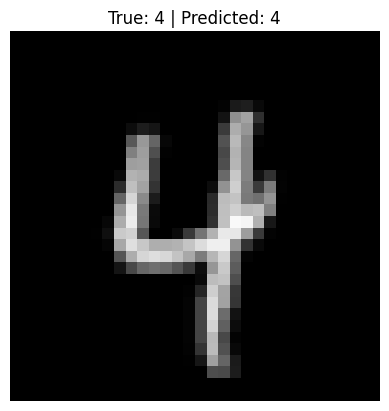

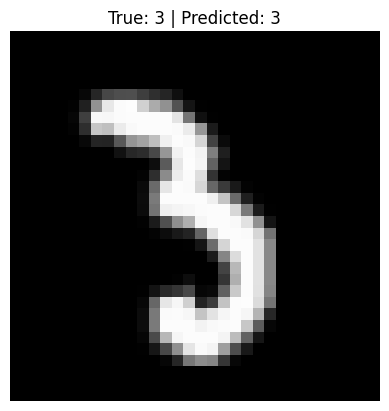

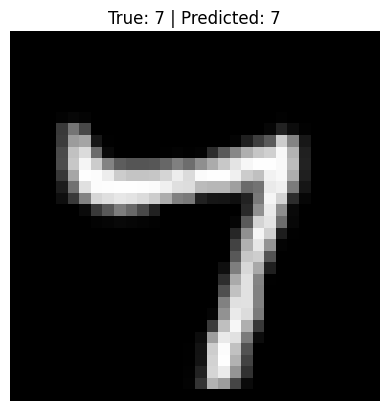

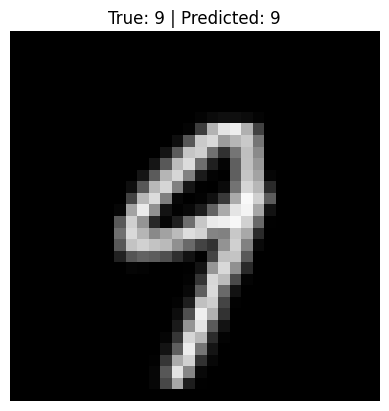

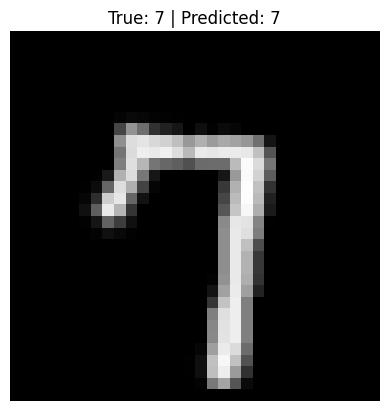

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert only X_test to numpy if it's a tensor
if isinstance(X_test, tf.Tensor):
    X_test_np = X_test.numpy()
else:
    X_test_np = X_test

# y_test is already a NumPy array
y_test_np = y_test

# Pick 5 random test samples
num_samples = 5
indices = np.random.choice(len(X_test_np), num_samples, replace=False)
sample_images = X_test_np[indices]
sample_labels = y_test_np[indices]

# Get predictions
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display each sample
for i in range(num_samples):
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_labels[i]} | Predicted: {predicted_classes[i]}")
    plt.axis('off')
    plt.show()
